**How to approach a supervised learning problem:**

1. Do some EDA.
2. Build a baseline model.
3. Do more EDA.
4. Engineer features.
5. Build a better model.

# 1

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/test.csv
/kaggle/input/train.csv
/kaggle/input/gender_submission.csv


In [2]:
# import datasets
df_train = pd.read_csv("../input/train.csv") 
df_test = pd.read_csv("../input/test.csv") 

# view first five lines of training data
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


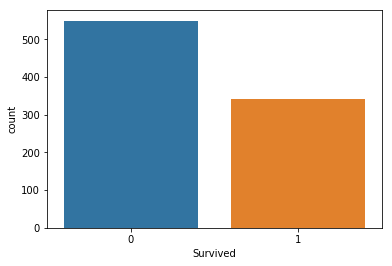

In [6]:
# plot of count(Survived)
sns.countplot(x="Survived", data=df_train)
plt.show()

More than 500 people didn't survive.

A few over 300 people survived.

So, we will predict that nobody survived as base model.

In [7]:
no_survived = pd.Series([0] * df_test.shape[0])

In [8]:
out = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': no_survived})

In [9]:
out.to_csv('no_survival.csv', index=False)

Accuracy: 62.7

# 2

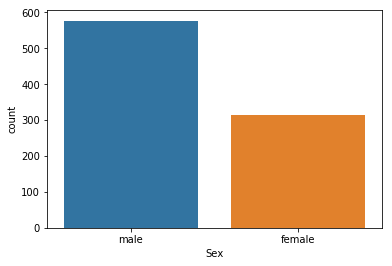

In [10]:
# plot count of male and female on titanic
sns.countplot(x="Sex", data=df_train);

There are more than 575 male and a little over 300 females, so let's check survival according to gender.

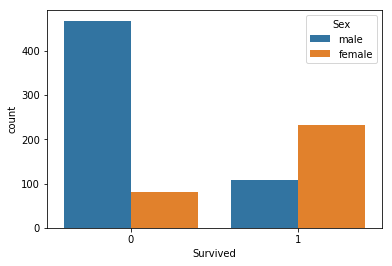

In [11]:
sns.countplot(x="Survived", hue='Sex', data=df_train);

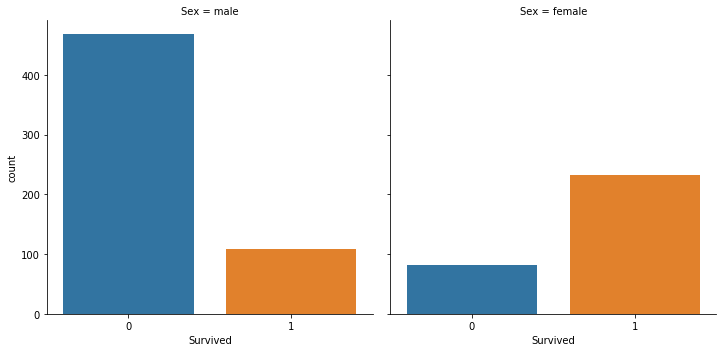

In [12]:
sns.catplot(x="Survived", col="Sex", kind="count", data=df_train);

We can see out of 300 female passengers, more than 200 survived whereas out of 600 male passengers about 100 survived.

**Take Away:** Women were more likely to survive than men.

In [13]:
df_train.groupby(['Sex']).Survived.sum()

Sex
female    233
male      109
Name: Survived, dtype: int64

In [14]:
df_train.groupby(["Sex"]).Survived.value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

In [15]:
print(df_train[df_train["Sex"]=="female"].Survived.sum() / df_train[df_train["Sex"]=="female"].shape[0]) 
# print(df_train[df_train["Sex"]=="female"].Survived.sum() / df_train[df_train["Sex"]=="female"].count()) 
print(df_train[df_train["Sex"]=="male"].Survived.sum() / df_train[df_train["Sex"]=="male"].shape[0]) 

0.7420382165605095
0.18890814558058924


About 74% of women survived and only 19% men survived.

Let's build a model that predicts all womens survived and no male survived.

In [16]:
women_survived_series = pd.Series(list(map(int, df_test["Sex"]=="female")))

In [17]:
out = pd.DataFrame({"PassengerId": df_test.PassengerId, "Survived": women_survived_series})
out.to_csv('all_women_survived.csv', index=False)

Accuracy: 76.5%

# 3

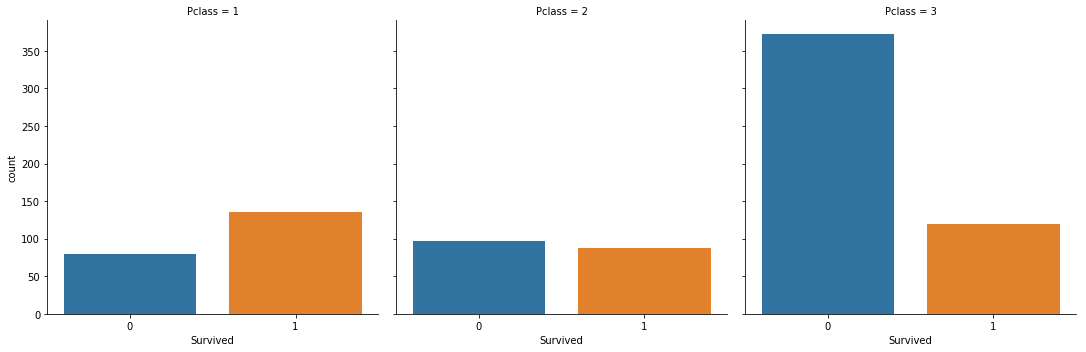

In [18]:
sns.catplot(x="Survived", col="Pclass", kind="count", data=df_train);

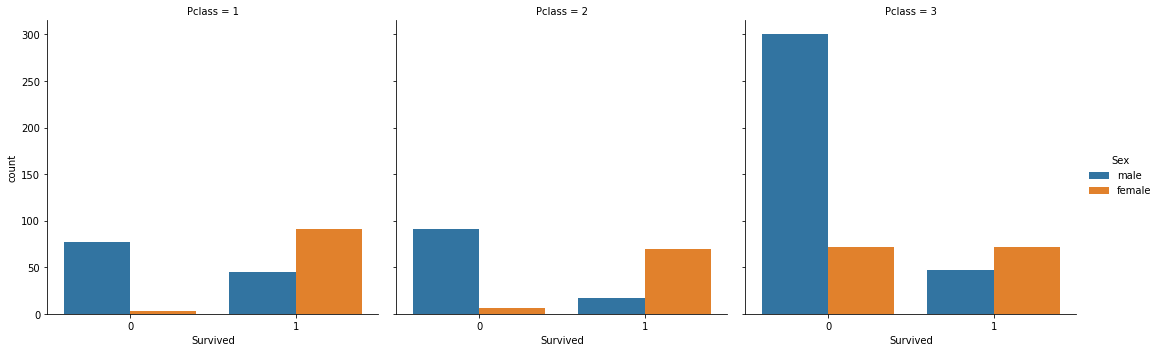

In [19]:
sns.catplot(x="Survived", col="Pclass", kind="count", hue="Sex", data=df_train);

- People with `Pclass=1` are more likely to survive i.e. rich people
- Very very few females did not survive in `Pclass=1` and `Pclass=2` whereas about 50% female did not survive in `Pclass=3`


In [20]:
print(df_train.groupby("Pclass").Survived.sum() / df_train.groupby("Pclass").Survived.count())

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


- About 63% people survived in `Pclass=1`
- About 47% people survived in `Pclass=2`
- About 24% people survived in `Pclass=2`

Port of Embarkation
- C = Cherbourg
- Q = Queenstown
- S = Southampton

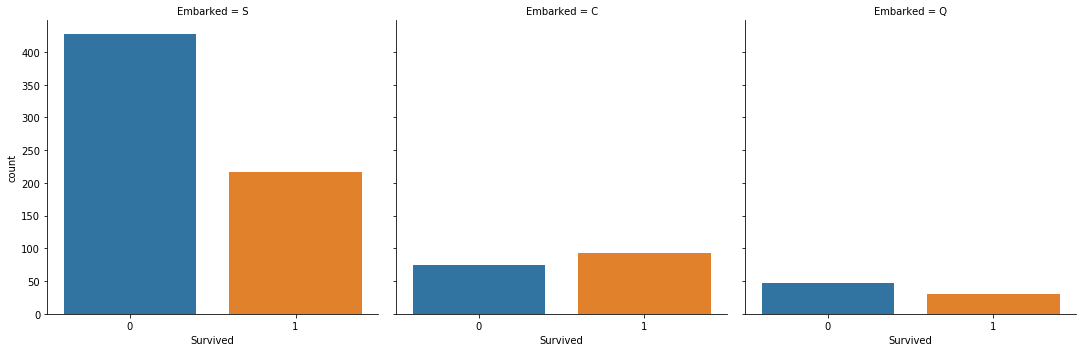

In [21]:
sns.catplot(x="Survived", col="Embarked", kind="count", data=df_train);

In [22]:
#sns.catplot(x="Embarked", col="Survived", kind="count", data=df_train);

- Those who embarked from `C` had greater chances of survival (55%). 
- Q (39%)
- S (33%)

In [23]:
print(df_train.groupby("Embarked").Survived.sum() / df_train.groupby("Embarked").Survived.count())

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


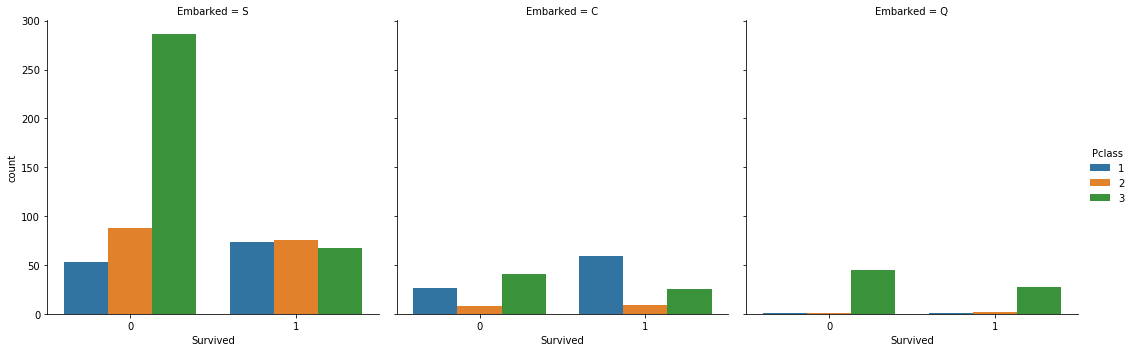

In [24]:
sns.catplot(x="Survived", col="Embarked", hue="Pclass", kind="count", data=df_train);

In [25]:
# df_train.groupby("Embarked").Survived.sum()  # shows number of people survived from each embarked point
# df_train.groupby("Embarked").Survived.count() # shows number of poeple embarked form each port

**EDA with numerical variables**

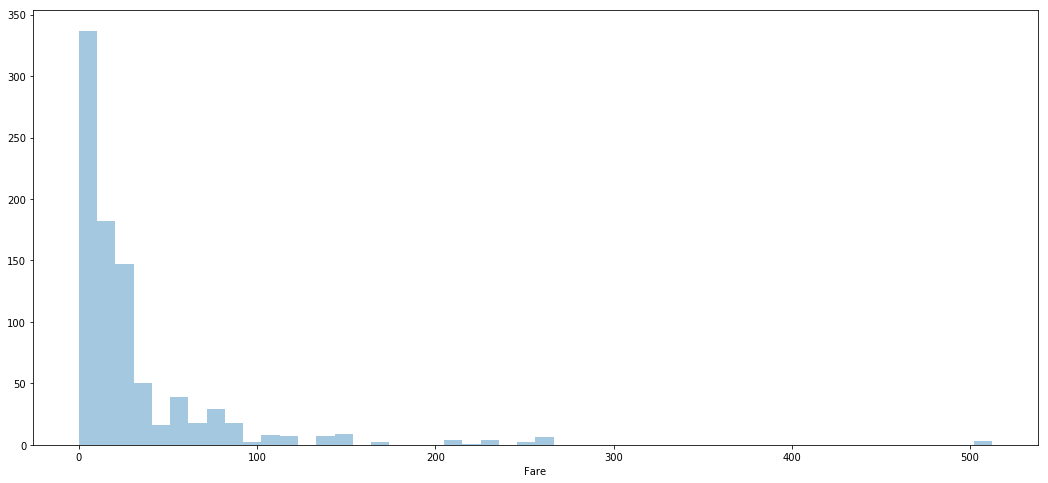

In [26]:
plt.figure(figsize=(18, 8))
sns.distplot(a=df_train.Fare, kde=False);

- Three passengers with fare greater than 300 (`Fare=512.3292`), and all of them survived.
- About 340 passengers paid less than 10\$
- Very few passengers with fare more than 50\$

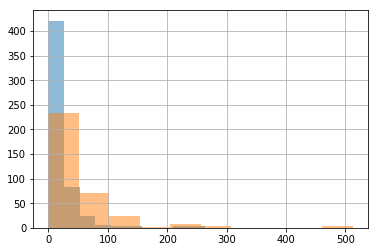

In [27]:
# Use a pandas plotting method to plot the column 'Fare' for each value of 'Survived' on the same plot.
df_train.groupby('Survived').Fare.hist(alpha=0.5);

- Those who paid more had more chances of survival.

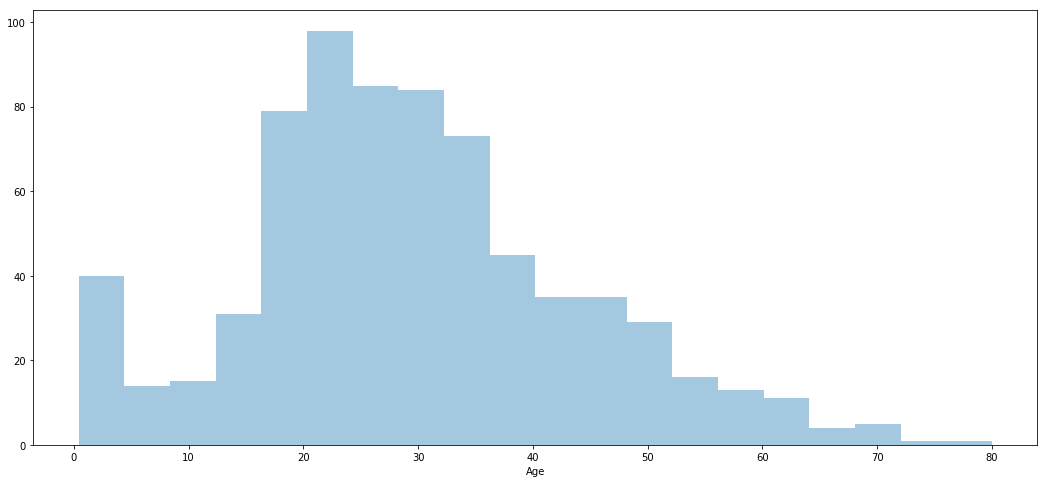

In [28]:
df_train_drop = df_train.Age.dropna()
plt.figure(figsize=(18, 8))
sns.distplot(a=df_train_drop, kde=False);

- Most of the passengers are young

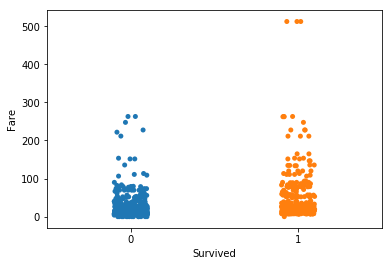

In [29]:
sns.stripplot(x="Survived", y="Fare", data=df_train);

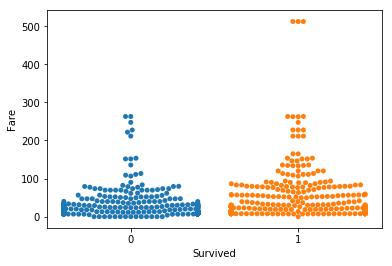

In [30]:
sns.swarmplot(x="Survived", y="Fare", data=df_train);

In [31]:
df_train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [32]:
# Use the DataFrame method .describe() to check out summary statistics of 'Fare' as a function of survival.
df_train.groupby('Survived').Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,22.117887,31.388207,0.0,7.8542,10.5,26.0,263.0000
1,342.0,48.395408,66.596998,0.0,12.4750,26.0,57.0,512.3292


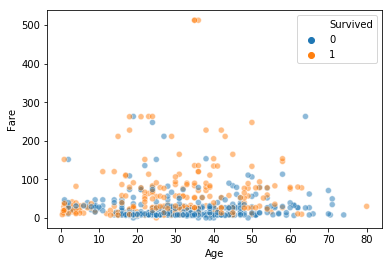

In [33]:
sns.scatterplot(x="Age", y="Fare", hue="Survived", data=df_train, alpha=0.5);

- Those who survived and paid low fare were more likely to be children.

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


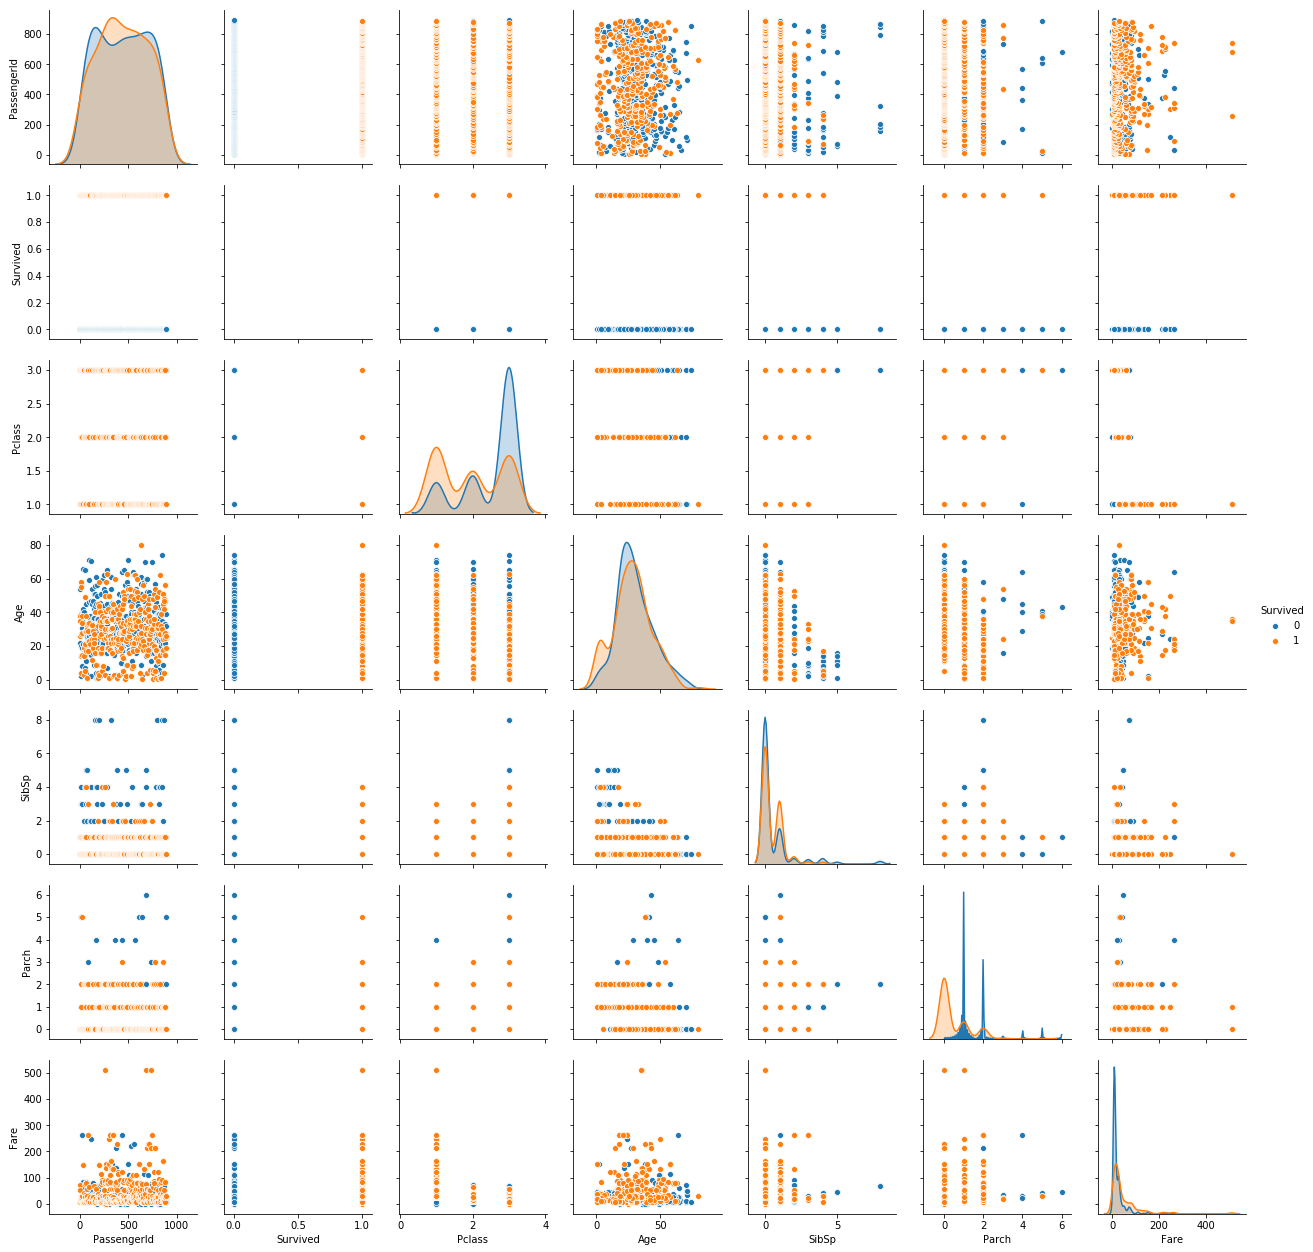

In [34]:
sns.pairplot(data=df_train, hue="Survived");

# 3

In [35]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Figures inline and set visualization style
%matplotlib inline
sns.set()

# Import data
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [36]:
# target variable
survived_train = df_train.Survived
# concatenate train and test set (to perform same data manipulation on both datasets)
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


We have 2 numerical columns with missing values, so perform imputation

In [38]:
data['Age'] = data.Age.fillna(data.Age.median())
data['Fare'] = data.Fare.fillna(data.Fare.median())
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [39]:
data = pd.get_dummies(data, columns=["Sex"], drop_first=True)
data.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,1,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,0
4,5,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1


In [40]:
data = data[["Pclass", "Age", "SibSp", "Fare", "Sex_male"]]
data.head()

,Pclass,Age,SibSp,Fare,Sex_male
0,3,22.0,1,7.2500,1
1,1,38.0,1,71.2833,0
2,3,26.0,0,7.9250,0
3,1,35.0,1,53.1000,0
4,3,35.0,0,8.0500,1


In [41]:
data_train = data.iloc[:891]
data_test = data.iloc[891:]

In [42]:
X = data_train.values
test = data_test.values
y = survived_train.values

In [43]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [44]:
Y_pred = clf.predict(test)
out = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': Y_pred})

In [45]:
out.to_csv('DecisionTree3.csv', index=False)

Accuracy: 76.5%

Accuracy: 78% (2nd time due to random initialization)

In [46]:
# plt.figure(figsize=(10, 10))
# tree.plot_tree(clf.fit(X, y));

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

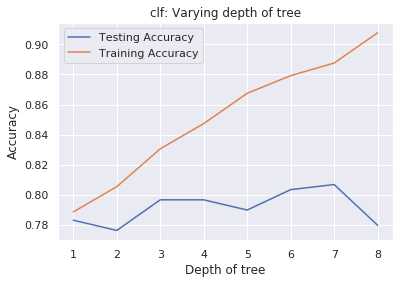

In [48]:
# Setup arrays to store train and test accuracies
dep = np.arange(1, 9)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a k-NN Classifier with k neighbors: knn
    clf = tree.DecisionTreeClassifier(max_depth=k)

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

# 4

In [49]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import GridSearchCV

# Figures inline and set visualization style
%matplotlib inline
sns.set()

# Import data
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

# Store target variable of training data in a safe place
survived_train = df_train.Survived

# Concatenate training and test sets
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])

# View head
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
data.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [51]:
data.Name.tail()

413              Spector, Mr. Woolf
414    Oliva y Ocana, Dona. Fermina
415    Saether, Mr. Simon Sivertsen
416             Ware, Mr. Frederick
417        Peter, Master. Michael J
Name: Name, dtype: object

we can extract titles from Name column to create a new feature

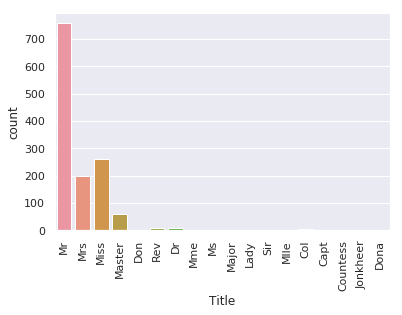

In [52]:
data['Title'] = data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(data.Title)
plt.xticks(rotation=90);

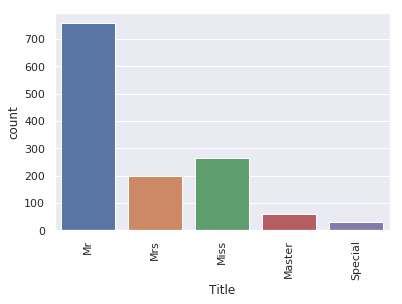

In [53]:
data['Title'] = data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                            'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.countplot(x='Title', data=data);
plt.xticks(rotation=90);

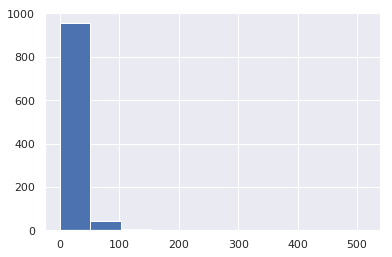

In [54]:
data[data.Cabin.isnull()].Fare.hist()

Several NaN values in `Cabin`. This may suggest those people didn't have a Cabin because it is NaN for those who paid low fare as shown in plot above. 

So we can create a new feature `hasCabin` showing whether they had cabin or not.

In [55]:
data['hasCabin'] = ~data.Cabin.isnull()
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,hasCabin
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False


In [56]:
# drop columns ['PassengerId', 'Name', 'Ticket', 'Cabin']
data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,hasCabin
0,3,male,22.0,1,0,7.2500,S,Mr,False
1,1,female,38.0,1,0,71.2833,C,Mrs,True
2,3,female,26.0,0,0,7.9250,S,Miss,False
3,1,female,35.0,1,0,53.1000,S,Mrs,True
4,3,male,35.0,0,0,8.0500,S,Mr,False


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Pclass      1309 non-null int64
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Fare        1308 non-null float64
Embarked    1307 non-null object
Title       1309 non-null object
hasCabin    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 133.3+ KB


We have missing values in columns `['Age', 'Fare', 'Embarked']`. Now we need to impute these missing values before we can proceed further

In [58]:
data['Age'] = data.Age.fillna(data.Age.median())
data['Fare'] = data.Fare.fillna(data.Fare.median())
data['Embarked'] = data.Embarked.fillna('S')    # as most of passsengers embarked from Southampton
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Pclass      1309 non-null int64
Sex         1309 non-null object
Age         1309 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Fare        1309 non-null float64
Embarked    1309 non-null object
Title       1309 non-null object
hasCabin    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 133.3+ KB


Binning

In [59]:
data['CatAge'] = pd.qcut(data.Age, q=4, labels=False)
data['CatFare'] = pd.qcut(data.Fare, q=4, labels=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
Pclass      1309 non-null int64
Sex         1309 non-null object
Age         1309 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Fare        1309 non-null float64
Embarked    1309 non-null object
Title       1309 non-null object
hasCabin    1309 non-null bool
CatAge      1309 non-null int64
CatFare     1309 non-null int64
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 153.8+ KB


In [60]:
# Now we can drop 'Age' and 'Fare' column
data.drop(['Age', 'Fare'], axis=1, inplace=True)
data.head()

,Pclass,Sex,SibSp,Parch,Embarked,Title,hasCabin,CatAge,CatFare
0,3,male,1,0,S,Mr,False,0,0
1,1,female,1,0,C,Mrs,True,3,3
2,3,female,0,0,S,Miss,False,1,1
3,1,female,1,0,S,Mrs,True,2,3
4,3,male,0,0,S,Mr,False,2,1


- SibSp: Number of siblings or spouse onboard
- Parch: Number of parents or children onboard

So we can create a new feature 'Fam_Size' and drop these two colunns

In [61]:
data['FamSize'] = data.SibSp + data.Parch
data.head()

,Pclass,Sex,SibSp,Parch,Embarked,Title,hasCabin,CatAge,CatFare,FamSize
0,3,male,1,0,S,Mr,False,0,0,1
1,1,female,1,0,C,Mrs,True,3,3,1
2,3,female,0,0,S,Miss,False,1,1,0
3,1,female,1,0,S,Mrs,True,2,3,1
4,3,male,0,0,S,Mr,False,2,1,0


In [62]:
# drop 'SibSp' and 'Parch'
data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
data.head()

,Pclass,Sex,Embarked,Title,hasCabin,CatAge,CatFare,FamSize
0,3,male,S,Mr,False,0,0,1
1,1,female,C,Mrs,True,3,3,1
2,3,female,S,Miss,False,1,1,0
3,1,female,S,Mrs,True,2,3,1
4,3,male,S,Mr,False,2,1,0


Now we need to convert non numerical columns to numerical columns.

In [63]:
data_dum = pd.get_dummies(data, drop_first=True)
data_dum.head()

,Pclass,hasCabin,CatAge,CatFare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,3,False,0,0,1,1,0,1,0,1,0,0
1,1,True,3,3,1,0,0,0,0,0,1,0
2,3,False,1,1,0,0,0,1,1,0,0,0
3,1,True,2,3,1,0,0,1,0,0,1,0
4,3,False,2,1,0,1,0,1,0,1,0,0


In [64]:
data_train = data_dum[:891]
data_test = data_dum[891:]

X = data_train.values
y = survived_train.values
test = data_test.values

Build model

In [65]:
# setup the hyperparameter grid
dep = np.arange(1, 9)
param_grid = {'max_depth': dep}

clf = tree.DecisionTreeClassifier()
clf_cv = GridSearchCV(clf, param_grid=param_grid, cv=5)
clf_cv.fit(X, y)

print("Tuned Decision Tree Parameters: {}".format(clf_cv.best_params_))
print("Best score is {}".format(clf_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 3}
Best score is 0.8294051627384961


In [66]:
y_pred = clf_cv.predict(test)

In [67]:
out = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': y_pred})
out.to_csv('feature_engg4.csv', index=False)

Accuracy: 